In [3]:
!pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-jy8kv8_p
  Running command git clone --filter=blob:none -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-jy8kv8_p
  Resolved https://github.com/qubvel/classification_models.git to commit a0f006e05485a34ccf871c421279864b0ccd220b
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 50 kB 726 kB/s            
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-py3-none-any.whl size=20045 sha256=11c7ca03c388c61d4fe8f73723dcb335dc911d865eb606d73e4c530463cc6fc6
  Stored in directory: /tmp/pip-ephem-wheel-cache-bcmk8p8i/wheels/0b/96/56/27b17c903efc647c51e4f364bfc20aa67f8d3dccad63c4fb4e
Successfully built image-classifiers


In [4]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from classification_models.tfkeras import Classifiers
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tqdm
import shutil

# Exploring the dataset

In [5]:
metadata_train = pd.read_csv('../input/fetalultrasoundbrain/train.csv')
metadata_test = pd.read_csv('../input/fetalultrasoundbrain/test.csv')

In [6]:
print("Training DataFrame : \n")
print(metadata_train.info(), "\n")
with pd.option_context('display.max_rows', 5):
    display(metadata_train)
    
print("""\n\n-------------------------------------
\n\nTesting DataFrame :
""")
print(metadata_test.info(), "\n")
with pd.option_context('display.max_rows', 5):
    display(metadata_test)

Training DataFrame : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  2500 non-null   object
 1   class       2500 non-null   object
dtypes: object(2)
memory usage: 39.2+ KB
None 



,image_name,class
0,Patient00168_Plane3_1_of_3,Trans-thalamic
1,Patient00168_Plane3_2_of_3,Trans-thalamic
...,...,...
2498,Patient01560_Plane3_4_of_4,Trans-thalamic
2499,Patient01562_Plane3_1_of_1,Trans-ventricular




-------------------------------------


Testing DataFrame :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592 entries, 0 to 591
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_name  592 non-null    object 
 1   class       0 non-null      float64
dtypes: float64(1), object(1)
memory usage: 9.4+ KB
None 



,image_name,class
0,Patient01563_Plane3_1_of_3,NaN
1,Patient01563_Plane3_2_of_3,NaN
...,...,...
590,Patient01791_Plane3_3_of_3,NaN
591,Patient01792_Plane3_1_of_1,NaN


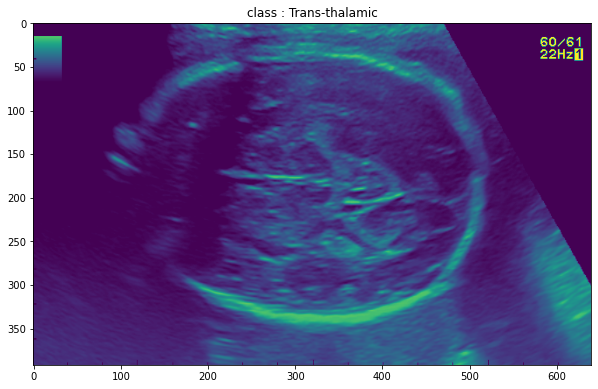

In [7]:
datapath = "../input/fetalultrasoundbrain/data/data"

img = plt.imread(os.path.join(datapath, metadata_train.iloc[0]['image_name']) + ".png")
plt.figure(figsize=(10, 10))
plt.title('class : ' + metadata_train.iloc[0]['class'])
plt.imshow(img)

In [8]:
img.shape

(392, 640)

In [9]:
img

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.14117648, 0.13333334, ..., 0.32156864, 0.30588236,
        0.29803923],
       [0.        , 0.14901961, 0.14901961, ..., 0.2901961 , 0.2784314 ,
        0.26666668],
       [0.        , 0.14901961, 0.15294118, ..., 0.26666668, 0.25882354,
        0.25490198]], dtype=float32)

# Preparing the data

In [10]:
X_train, X_valid= train_test_split( metadata_train, test_size=0.3, random_state=42 )

In [11]:
classes = {
        'Trans-cerebellum' : 0,
        'Trans-thalamic' : 1,
        'Trans-ventricular' : 2,
        'Other' : 3
    }

In [12]:
out_dir = '/kaggle/working/out'
train_dir = '/kaggle/working/out/train'
test_dir = '/kaggle/working/out/test'
valid_dir = '/kaggle/working/out/valid'

try :
    shutil.rmtree(out_dir)
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))

Error: /kaggle/working/out - No such file or directory.


In [13]:
## Create the folders representing each class 

try :
    os.mkdir(out_dir)
    os.mkdir(train_dir)
    os.mkdir(test_dir)
    os.mkdir(valid_dir)
except OSError as e:
    #print("Creation of folder {} failed".format(train_dir))
    print("Error: %s - %s." % (e.filename, e.strerror))
    
for class_name in list(classes.keys()) :
    try :
        os.mkdir(os.path.join(train_dir, class_name))
        os.mkdir(os.path.join(valid_dir, class_name))
    except OSError as e :
        print("Error: %s - %s." % (e.filename, e.strerror))


In [14]:
## copy images to their respective folders 

for index_num,row in tqdm.tqdm( X_train.iterrows() ):
    filename = os.path.join(datapath, row['image_name'] + '.png')
    try :
        shutil.copy(filename, os.path.join(train_dir, row['class']))
    except :
        print("Error occured while copying...")

1750it [00:21, 82.93it/s] 


In [15]:
for index_num,row in tqdm.tqdm( X_valid.iterrows() ):
    filename = os.path.join(datapath, row['image_name'] + '.png')
    try :
        shutil.copy(filename, os.path.join(valid_dir, row['class']))
    except :
        print("Error occured while copying...")

750it [00:06, 113.91it/s]


In [16]:
## Copy test images to the test_dir 

for index_num,row in tqdm.tqdm( metadata_test.iterrows() ):
    filename = os.path.join(datapath, row['image_name'] + '.png')
    try :
        shutil.copy(filename, os.path.join(test_dir))
    except :
        print("Error occured while copying...")

592it [00:05, 115.70it/s]


We'll train 

In [17]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        #rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
)

In [18]:
test_generator = tf.keras.preprocessing.image.ImageDataGenerator().flow_from_directory(
        '/kaggle/working/out/',
        target_size = (300, 300),
        classes = ['test'],
        shuffle = False,
        batch_size = 1,
)

Found 592 images belonging to 1 classes.


In [19]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = (300, 300),
#         color_mode = "grayscale",
        batch_size = 100,
        classes = list(classes.keys())
)

Found 1750 images belonging to 4 classes.


In [20]:
train_generator.class_indices

{'Trans-cerebellum': 0,
 'Trans-thalamic': 1,
 'Trans-ventricular': 2,
 'Other': 3}

In [21]:
valid_generator = train_datagen.flow_from_directory(
        valid_dir,
        target_size = (300, 300),
#         color_mode = "grayscale",
        batch_size = 100,
        classes = list(classes.keys())
)

Found 750 images belonging to 4 classes.


In [22]:
# def load_data(metadata, idx, batch_size) :
    
#     X = []
#     y = []
    
#     for index_num,row in tqdm.tqdm( metadata.iloc[idx * batch_size : idx * batch_size + batch_size].iterrows() ):
#         filename = os.path.join(datapath, row['image_name'] + '.png')
#         img = plt.imread(filename)
#         #df_train.loc[df_train.index[ df_train['image_name'] == row['image_name'] ].tolist()[0], 'image_data'] = img
#         X.append( img.tolist() )
#         y.append(classes[row['class']])

#     return (np.array(X), y)


# def batch_generator(df_train, batch_size, steps):
#     idx = 1
#     while True: 
#         yield load_data(df_train, idx - 1, batch_size)
#         if idx < steps :
#             idx += 1
#         else :
#             idx = 1

# Modeling 

In [23]:
print("Models :", *Classifiers.models_names())

Models : resnet18 resnet34 resnet50 resnet101 resnet152 seresnet18 seresnet34 seresnet50 seresnet101 seresnet152 seresnext50 seresnext101 senet154 resnet50v2 resnet101v2 resnet152v2 resnext50 resnext101 vgg16 vgg19 densenet121 densenet169 densenet201 inceptionresnetv2 inceptionv3 xception nasnetlarge nasnetmobile mobilenet mobilenetv2


In [24]:
ResNeXt101, preprocess_input = Classifiers.get('resnext101')

In [25]:
model_res = ResNeXt101(include_top = False, input_shape=(300, 300, 3), weights='imagenet')


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

173637632/173622728 [==============================] - 10s 0us/step


In [26]:
model_res.trainable = False

In [27]:
model = keras.Sequential([
    model_res, 
    
    layers.Flatten(),
    layers.Dense(units = 4, activation = "softmax")
])

In [28]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy']
)


In [29]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    min_delta = 0.001,
    restore_best_weights = True,
)

In [30]:
history = model.fit(
    train_generator,
    #steps_per_epoch = 2000,
    epochs = 50,
    validation_data = valid_generator,
    #validation_steps = 800,
    callbacks = [ early_stopping ], 
)

2022-01-18 17:33:57.142249: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
18/18 [==============================] - 796s 43s/step - loss: 22.0317 - categorical_accuracy: 0.4634 - val_loss: 11.8279 - val_categorical_accuracy: 0.5400
Epoch 2/50
18/18 [==============================] - 737s 41s/step - loss: 8.1664 - categorical_accuracy: 0.5720 - val_loss: 4.9780 - val_categorical_accuracy: 0.5747
Epoch 3/50
18/18 [==============================] - 736s 41s/step - loss: 4.9515 - categorical_accuracy: 0.6320 - val_loss: 3.5330 - val_categorical_accuracy: 0.6627
Epoch 4/50
18/18 [==============================] - 738s 41s/step - loss: 2.6768 - categorical_accuracy: 0.7217 - val_loss: 3.0688 - val_categorical_accuracy: 0.6627
Epoch 5/50
18/18 [==============================] - 736s 41s/step - loss: 1.6206 - categorical_accuracy: 0.7720 - val_loss: 3.3094 - val_categorical_accuracy: 0.6333
Epoch 6/50
18/18 [==============================] - 732s 41s/step - loss: 1.4933 - categorical_accuracy: 0.7600 - val_loss: 5.2742 - val_categorical_accuracy: 0.5707
Ep

In [31]:
history

<AxesSubplot:title={'center':'Accuracy'}>

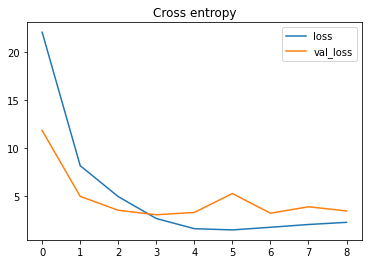

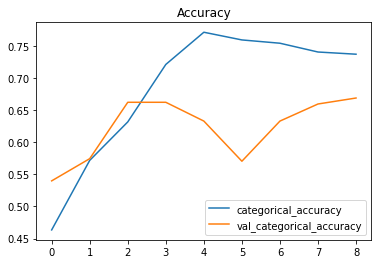

In [32]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross entropy")
history_df.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot(title="Accuracy")

# Predicting

In [36]:
filenames = test_generator.filenames
nb_samples = len(filenames)
# print(*filenames)

In [37]:
y_pred = model.predict_generator(
    test_generator,
    steps = nb_samples
)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [42]:
y_pred[0]

array([5.9846133e-07, 9.9999928e-01, 1.3252846e-07, 3.8799008e-26],
      dtype=float32)

In [44]:
classes = train_generator.class_indices
classes

{'Trans-cerebellum': 0,
 'Trans-thalamic': 1,
 'Trans-ventricular': 2,
 'Other': 3}

In [50]:
classes = {
    0 : 'Trans-cerebellum', 
    1 : 'Trans-thalamic',
    2 : 'Trans-ventricular',
    3 : 'Other'
}

In [53]:
filenames[0][5:-4]

'Patient01563_Plane3_1_of_3'

In [54]:
files = []
preds = []
for i in range(len(y_pred)):
    files.append(filenames[i][5:-4])
    preds.append( classes[np.argmax(y_pred[i])] )

In [57]:
submission = {
    'image_name' : files,
    'class' : preds
}

submission = pd.DataFrame.from_dict(submission)
submission.head()

,image_name,class
0,Patient01563_Plane3_1_of_3,Trans-thalamic
1,Patient01563_Plane3_2_of_3,Trans-cerebellum
2,Patient01563_Plane3_3_of_3,Trans-ventricular
3,Patient01564_Plane3_1_of_2,Trans-cerebellum
4,Patient01564_Plane3_2_of_2,Trans-thalamic


In [58]:
submission.to_csv('/kaggle/working/submission.csv', index = False)